In [9]:
# Adding src/ folder to import path
import sys

sys.path.append("../src")

In [22]:
import os.path

import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import swifter
from birdclef.load_data import *
from birdclef.postprocessing import *

DATA_PATH = "/workspace/Data/birdclef-2021"
SAMPLE_RATE = 32000
NORM_ENERGY = 100
N_MEL = 200

In [11]:
# Loading labels
df = load_labels(DATA_PATH)

# Creating labels for presence of call
df["is_call"] = df.apply(
    lambda x: 0 if x["birds"] == "nocall" else 1, axis=1
)

df

,row_id,site,audio_id,seconds,birds,is_call
0,7019_COR_5,COR,7019,5,nocall,0
1,7019_COR_10,COR,7019,10,nocall,0
2,7019_COR_15,COR,7019,15,nocall,0
3,7019_COR_20,COR,7019,20,nocall,0
4,7019_COR_25,COR,7019,25,nocall,0
...,...,...,...,...,...,...
2395,54955_SSW_580,SSW,54955,580,nocall,0
2396,54955_SSW_585,SSW,54955,585,grycat,1
2397,54955_SSW_590,SSW,54955,590,grycat,1
2398,54955_SSW_595,SSW,54955,595,nocall,0


In [12]:
df["is_call"].value_counts()

0    1529
1     871
Name: is_call, dtype: int64

In [13]:
# ---

In [14]:
date, signal = load_soundscape_audio(
    "7019_COR", DATA_PATH + "/train_soundscapes", SAMPLE_RATE
)

In [15]:
signal.shape

(19200000,)

In [19]:
def load_signal(row):
    file_prefix = "{}_{}".format(row["audio_id"], row["site"])
    row["date"], row["signal"] = load_soundscape_audio(
        file_prefix,
        DATA_PATH + "/train_soundscapes",
        sr=SAMPLE_RATE,
        offset=row["seconds"] - 5,
        duration=5,
    )

    return row


df = df.swifter.apply(load_signal, axis=1)
df

Pandas Apply:   0%|          | 0/2400 [00:00<?, ?it/s]

,row_id,site,audio_id,seconds,birds,is_call,signal,date
0,7019_COR_5,COR,7019,5,nocall,0,"[-0.08553279, -0.08384135, -0.041250665, -0.01...",20190904
1,7019_COR_10,COR,7019,10,nocall,0,"[0.021114878, 0.003057547, -0.02268604, 0.0004...",20190904
2,7019_COR_15,COR,7019,15,nocall,0,"[0.018344874, 0.04597478, 0.05685617, 0.049335...",20190904
3,7019_COR_20,COR,7019,20,nocall,0,"[-0.10187924, -0.13058019, -0.11406977, -0.125...",20190904
4,7019_COR_25,COR,7019,25,nocall,0,"[0.05506949, 0.050840594, 0.057296656, 0.06219...",20190904
...,...,...,...,...,...,...,...,...
2395,54955_SSW_580,SSW,54955,580,nocall,0,"[-0.03387017, -0.024345992, -0.016776666, -0.0...",20170617
2396,54955_SSW_585,SSW,54955,585,grycat,1,"[0.1394074, 0.14445972, 0.14525153, 0.14363474...",20170617
2397,54955_SSW_590,SSW,54955,590,grycat,1,"[-0.0086922, -0.013638088, -0.022163874, -0.01...",20170617
2398,54955_SSW_595,SSW,54955,595,nocall,0,"[0.055847555, 0.041066542, 0.025795452, 0.0165...",20170617


In [20]:
df.to_csv(DATA_PATH + "/outputs/train_detector.csv")

In [28]:
df["mel_spec"] = df["signal"].apply(lambda x: get_mel_spec(x))

In [33]:
spec_df = df[["mel_spec", "is_call"]]

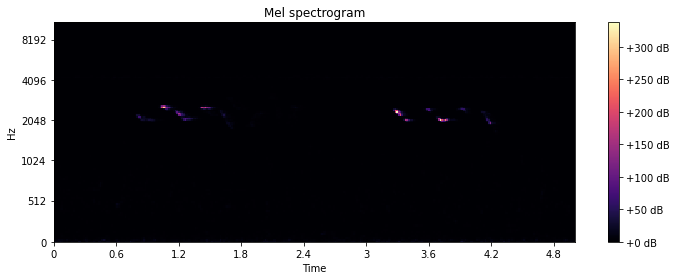

In [37]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(
    spec_df[spec_df["is_call"] == 1]["mel_spec"].iloc[0], 
    sr=SAMPLE_RATE, 
    y_axis="mel", 
    fmax=None, 
    x_axis="time"
)
plt.colorbar(format="%+2.0f dB")
plt.title("Mel spectrogram")
plt.tight_layout()

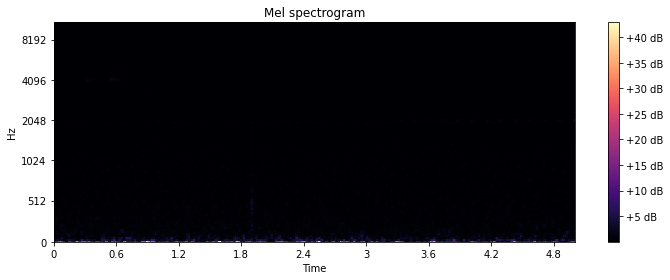

In [38]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(
    spec_df[spec_df["is_call"] == 0]["mel_spec"].iloc[0], 
    sr=SAMPLE_RATE, 
    y_axis="mel", 
    fmax=None, 
    x_axis="time"
)
plt.colorbar(format="%+2.0f dB")
plt.title("Mel spectrogram")
plt.tight_layout()

---

## Model

In [39]:
import keras
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

In [50]:
# Adding channel dimension needed for ConvNets
X = np.expand_dims(np.array(df["mel_spec"].to_list()), axis=3)
y = df["is_call"].to_numpy()

# Splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Compute class weights
weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
weights = {x: weights[x] for x in range(len(weights))}

In [51]:
weights

{0: 0.7894736842105263, 1: 1.3636363636363635}

In [64]:
x_size = X_train[0].shape[0]
y_size = X_train[0].shape[1]

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=20, 
                              input_shape=(x_size, y_size, 1), 
                              data_format="channels_last",
                              kernel_size=(20, 20),
                              strides=(1, 1),
                              activation='relu', 
                              kernel_initializer=keras.initializers.glorot_normal()))
model.add(keras.layers.MaxPooling2D(pool_size=(4, 4), 
                                    strides=(4, 4)))
model.add(keras.layers.Conv2D(filters=20, 
                              data_format="channels_last",
                              kernel_size=(10, 10),
                              strides=(1, 1),
                              activation='relu', 
                              kernel_initializer=keras.initializers.glorot_normal()))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), 
                                    strides=(2, 2)))
model.add(keras.layers.Conv2D(filters=20, 
                              data_format="channels_last",
                              kernel_size=(5, 5),
                              strides=(1, 1),
                              activation='relu', 
                              kernel_initializer=keras.initializers.glorot_normal()))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), 
                                    strides=(2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1, 
                             activation='sigmoid',
                             kernel_initializer=keras.initializers.glorot_normal()))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 109, 294, 20)      8020      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 27, 73, 20)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 18, 64, 20)        40020     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 9, 32, 20)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 5, 28, 20)         10020     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 2, 14, 20)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 560)              

In [68]:
batch_size=32
epochs = 10

callback = keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
model.fit(x=X_train, 
          y=y_train, 
          batch_size=batch_size, 
          epochs=epochs, 
          callbacks=[callback],
          validation_split=0.2,
          class_weight=weights)

Epoch 1/10
48/48 [==============================] - 165s 3s/step - loss: 0.3292 - accuracy: 0.8672 - val_loss: 0.8316 - val_accuracy: 0.8073
Epoch 2/10
48/48 [==============================] - 164s 3s/step - loss: 0.3098 - accuracy: 0.8652 - val_loss: 1.1297 - val_accuracy: 0.8021
Epoch 3/10
48/48 [==============================] - 161s 3s/step - loss: 0.2839 - accuracy: 0.8861 - val_loss: 0.9664 - val_accuracy: 0.8620
Epoch 4/10
48/48 [==============================] - 161s 3s/step - loss: 0.2832 - accuracy: 0.8750 - val_loss: 1.4411 - val_accuracy: 0.7240
Epoch 5/10
48/48 [==============================] - 162s 3s/step - loss: 0.2669 - accuracy: 0.8952 - val_loss: 1.3965 - val_accuracy: 0.8490
Epoch 6/10
48/48 [==============================] - 161s 3s/step - loss: 0.4131 - accuracy: 0.8600 - val_loss: 1.0894 - val_accuracy: 0.7917
Epoch 7/10
48/48 [==============================] - 161s 3s/step - loss: 0.3125 - accuracy: 0.8652 - val_loss: 1.1879 - val_accuracy: 0.8359
Epoch 8/10
48

## Model performance

In [69]:
from sklearn.metrics import roc_curve, auc

In [ ]:
y_test_pred = model.predict(x=X_test)

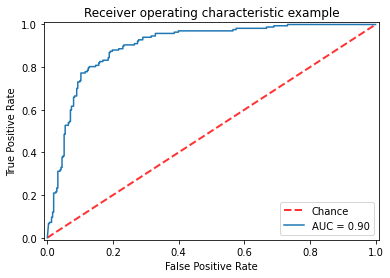

In [70]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.plot(fpr, tpr, label=r'AUC = %0.2f' % (auc(fpr, tpr)))
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")